In [1]:
# imports
import torch
import sys
from pathlib import Path

path = Path.cwd().parents[1]
if str(path) not in sys.path:
    sys.path.append(str(path))

from src.BayesIMPfull import BayesIMP as BayesIMPfull
from src.BayesIMP import *
from src.kernels import *
from src.dgps import *

seed = 0
n = 100
ntest = 100
d = 5
noise = 0.5
niter = 500
learn_rate = 0.1
optimise_mu = False
exact = True
mc_samples = 100
kernel = "gaussian"

torch.manual_seed(seed)

""" Fixed configs """
default_nu = 1.0
reg = 1e-3
quantiles = torch.linspace(0,1,101)[:,None]

if kernel == "gaussian":
    Kernel = GaussianKernel
else:
    Kernel = GammaExponentialKernel
    exact = False

""" Draw data """
Z, V, Y, doZ, YdoZ, EYdoZ = Abelation(n, ntest, d, noise, doZlower = 0, doZupper = 1, mc_samples_EYdoZ = 10**4, seed = seed) 

""" Initialise model """
modelfull = BayesIMPfull(Kernel_A = Kernel, 
               Kernel_V = Kernel, 
               dim_A = Z.size()[1], 
               dim_V = V.size()[1], 
               samples = 10**5,
               exact = exact)
model = BayesIMP(Kernel_A = Kernel, 
               Kernel_V = Kernel, 
               dim_A = Z.size()[1], 
               dim_V = V.size()[1], 
               samples = 10**5,
               exact = exact)

""" Train model """
modelfull.train(Y,Z,V,niter=niter,learn_rate=learn_rate, optimise_measure = optimise_mu, mc_samples = mc_samples, reg = reg)
model.train(Y,Z,V,niter=niter,learn_rate=learn_rate, optimise_measure = optimise_mu, mc_samples = mc_samples, reg = reg)

""" Get Posterior moments """
meanfull = modelfull.post_mean(Y, Z, V, doA = doZ, reg = reg).detach()
varfull = modelfull.post_var(Y, Z, V, doA = doZ, reg = reg, latent = True, diag = True).detach()
mean = model.post_mean(Y, Z, V, doA = doZ, reg = reg).detach()
var = model.post_var(Y, Z, V, doA = doZ, reg = reg, latent = True, diag = True).detach()

""" Compute out of sample metrics """
z_quantiles = Normal(0, 1).icdf(1-(1-quantiles)/2)
posterior_fraction = ((EYdoZ - mean).abs() <= var**0.5 @ z_quantiles.T).float()
rmse = ((EYdoZ - mean)**2).mean()**0.5

/nfs/ghome/live/danceh/Causal-GP/causal-KL-GP/src/dgps.py:28: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1724888750493/work/aten/src/ATen/native/TensorShape.cpp:3697.)
  VdoZ = (f_x(doZ,coefs_v)).T[:,:,None] @ torch.ones(mc_samples_EYdoZ).view(1,mc_samples_EYdoZ) + noise_distribution.sample((mc_samples_EYdoZ,ntest)).T
/nfs/ghome/live/danceh/Causal-GP/causal-KL-GP/src/BayesIMPfull.py:101: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.kernel_V.dist.scale = torch.tensor(measure_init*V[1].var()**0.5).requires_grad_(op

iter 0 P(Y|V) loss:  tensor(195.3830)
iter 100 P(Y|V) loss:  tensor(3.8040)
iter 200 P(Y|V) loss:  tensor(3.7889)
iter 300 P(Y|V) loss:  tensor(3.7885)
iter 400 P(Y|V) loss:  tensor(3.7886)
iter 0 P(V|A) loss:  tensor(-18300.5840)
iter 100 P(V|A) loss:  tensor(-29979.9453)
iter 200 P(V|A) loss:  tensor(-29980.1680)
iter 300 P(V|A) loss:  tensor(-29980.1660)
iter 400 P(V|A) loss:  tensor(-29980.1719)


/nfs/ghome/live/danceh/Causal-GP/causal-KL-GP/src/BayesIMP.py:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.kernel_V.dist.scale = torch.tensor(measure_init*V[1].var()**0.5).requires_grad_(optimise_measure)


iter 0 P(Y|V) loss:  tensor(195.3830)
iter 100 P(Y|V) loss:  tensor(3.8040)
iter 200 P(Y|V) loss:  tensor(3.7889)
iter 300 P(Y|V) loss:  tensor(3.7885)
iter 400 P(Y|V) loss:  tensor(3.7886)
iter 0 P(V|A) loss:  tensor(-18300.5840)
iter 100 P(V|A) loss:  tensor(-29979.9453)
iter 200 P(V|A) loss:  tensor(-29980.1680)
iter 300 P(V|A) loss:  tensor(-29980.1660)
iter 400 P(V|A) loss:  tensor(-29980.1719)
torch.Size([100]) torch.Size([100]) torch.Size([100])


In [3]:
import matplotlib.pyplot as plt

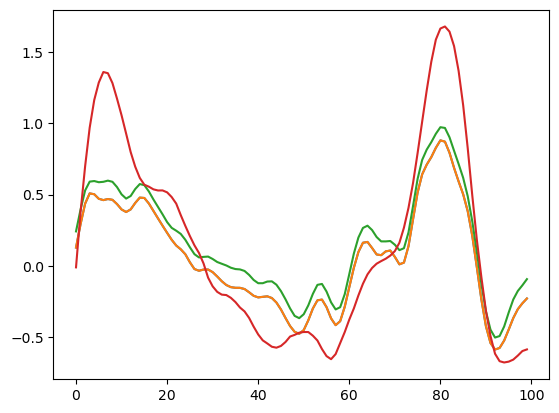

In [5]:
plt.plot(mean-var)
plt.plot(meanfull-varfull)
plt.plot(meanfull+varfull)

plt.plot(EYdoZ)

In [13]:
A = Z
W = None
doA = doZ
doA2 = doA
doW,doW2 = None,None
reg = reg
latent = True
diag = True
average_doA = False

In [14]:
self = model
"""BayesIMP"""
if not self.exact:
    self.kernel_V.samples = samples

# Getting second set of doA if computing covariance
if doA2 ==[]:
    doA2 = doA
    
# Dimensions
n = len(Y)
n0, N, M, D = len(A), len(doA), len(doA2), A.shape[1]
Y = Y.reshape(n, 1)

# Expand doA with replacement using the selected columns from A
if average_doA:
    average_indices = [j for j in range(D) if j not in intervention_indices]
    expanded_doA = self.expand_doA(doA, A, intervention_indices)  # Shape (n0*N, D)
    expanded_doA2 = self.expand_doA(doA2, A, intervention_indices)  # Shape (n0*M, D)
else:
    assert doA.shape[1] == A.shape[1]
    assert doA2.shape[1] == A.shape[1]
    expanded_doA = doA  # No expansion if not averaging, expanded_doA: (N, D)
    expanded_doA2 = doA2  # No expansion if not averaging, expanded_doA: (M, D)

# One dataset case
if type(V) != list:
    
    # Getting kernel matrices
    R_vv, K_vv, K_aa, k_atest, k_atest2 = (
        self.kernel_V.get_gram(V, V),
        self.kernel_V.get_gram_base(V, V),
        self.kernel_A.get_gram(A, A),
        self.kernel_A.get_gram(expanded_doA, A),
        self.kernel_A.get_gram(expanded_doA2, A)
    )
    R_v = R_vv + (self.noise_Y.exp() + reg) * torch.eye(n)
    K_v = K_vv + (self.noise_Y.exp() + reg) * torch.eye(n)
    K_a = K_aa + (self.noise_feat.exp() + reg) * torch.eye(n)
    R_vv_bar = R_vv - R_vv @ torch.linalg.solve(R_v, R_vv)

    # Averaging out selected indices
    if average_doA:
        k_atest = k_atest.reshape(n0,N,n0).mean(0) # (N,n0)
        k_atest2 = k_atest2.reshape(n0,M,n0).mean(0) # (M,n0)            
    
    # Computing matrix vector products
    beta_a = torch.linalg.solve(K_a, k_atest.T)  # (n0, N)
    beta_a2 = torch.linalg.solve(K_a, k_atest2.T)  # (n0, N)
    alpha_y = torch.linalg.solve(R_v, Y)  # (n1, 1)
    KinvR = torch.linalg.solve(K_vv + torch.eye(n) * reg, R_vv)  # (n1, n1)
  
    # Get gram matrix on doA,doA2
    if average_doA: 
        
        # If averaging, define separate kernels for averaging and intervention indices
        kernel_Aavg = deepcopy(self.kernel_A)
        kernel_Aavg.lengthscale = self.kernel_A.lengthscale[average_indices]
        kernel_Aavg.scale = 1.0

        kernel_doA = deepcopy(self.kernel_A)
        kernel_doA.lengthscale = self.kernel_A.lengthscale[intervention_indices]
        
        # Construct average and interventional gram matrices
        Aavg = A[:,average_indices].reshape(n0,len(average_indices))
        K_Aavg = kernel_Aavg.get_gram(Aavg,Aavg).mean()
        K_doA = kernel_doA.get_gram(doA,doA2)

        K_atestatest = K_Aavg*K_doA
    else:
        # otherwise, just construct N x M gram matrix on doA 
        K_atestatest = self.kernel_A.get_gram(doA,doA2)
    
    # Final computations
    if not diag:
        kpost_atest = K_atestatest - k_atest @ torch.linalg.solve(K_a, k_atest2.T) # (N,M)
        V_1 = beta_a.T @ R_vv_bar @ beta_a2  # (N,M)
        V_2 = kpost_atest * (alpha_y.T @ R_vv @ KinvR @ KinvR @ alpha_y).view(-1)  # (N,M)
        V_3 = kpost_atest * torch.trace(torch.linalg.solve(K_vv + torch.eye(n) * reg, R_vv_bar @ KinvR))  # (N,M)
        posterior_variance = V_1 + V_2 + V_3  # (N,N)

    else:
        kpost_atest = K_atestatest.diag() - (torch.linalg.solve(K_a, k_atest2.T)*k_atest.T).sum(0) # (N,)
        V_1 = ((R_vv_bar @ beta_a2)*beta_a).sum(0)  # (N,)
        V_2 = kpost_atest * (alpha_y.T @ R_vv @ KinvR @ KinvR @ alpha_y).view(-1)  # (N,)
        V_3 = kpost_atest * torch.trace(torch.linalg.solve(K_vv + torch.eye(n) * reg, R_vv_bar @ KinvR))  # (N,)

        posterior_variance = (V_1 + V_2 + V_3).reshape(N,1)  # (N,1)

In [24]:
self = modelfull
"""BayesIMP full"""
if not self.exact:
    self.kernel_V.samples = samples

# Getting second set of doA and doW if computing covariance
if doA2 == None:
    doA2 = doA
if doW2 == None and doW != None:
    doW2 = doW

# Dimensions
n = len(Y)
n0, N, M, D = len(A), len(doA), len(doA2), A.shape[1]
Y = Y.reshape(n, 1)
    
# Expand doA with replacement using the selected columns from A
if average_doA:
    average_indices = [j for j in range(D) if j not in intervention_indices]
    expanded_doA = self.expand_doA(doA, A, intervention_indices)  # Shape (n0*N, D)
    expanded_doA2 = self.expand_doA(doA2, A, intervention_indices)  # Shape (n0*M, D)
else:
    assert doA.shape[1] == A.shape[1]
    assert doA2.shape[1] == A.shape[1]
    expanded_doA = doA  # No expansion if not averaging, expanded_doA: (N, D)
    expanded_doA2 = doA2  # No expansion if not averaging, expanded_doA: (M, D)

# One dataset case
if type(V) != list:

    if W != None:
        WV = [W,V]
        N_w = len(doW)
        M_w = len(doW2)
    else:
        WV = V
        N_w = 1
        M_w = 1
    
    # Getting kernel matrices
    R_wvwv,R_vv, K_vv, K_aa, k_atest, k_atest2 = (
        self.kernel_WV.get_gram(WV, WV),
        self.kernel_V.get_gram(V, V),
        self.kernel_V.get_gram_base(V, V),
        self.kernel_A.get_gram(A, A),
        self.kernel_A.get_gram(expanded_doA, A),
        self.kernel_A.get_gram(expanded_doA2, A)
    )
    R_wv = R_wvwv + (self.noise_Y.exp() + reg) * torch.eye(n)
    K_a = K_aa + (self.noise_feat.exp() + reg) * torch.eye(n)
    R_wvwv_bar = R_wvwv - R_wvwv @ torch.linalg.solve(R_wv, R_wvwv)

    if W != None and doW!= None:
        K_wtestwtest = self.kernel_W.get_gram_base(doW,doW2) # (N_w, M_w)
        k_wtest = self.kernel_W.get_gram_base(doW,W) # (N_w, n1)
        k_wtest2 = self.kernel_W.get_gram_base(doW2,W) # (M_w, n1)
        K_ww = self.kernel_W.get_gram_base(W,W)
    else:
        K_wtestwtest = torch.ones((1,1))
        k_wtest = torch.ones((1,n))
        k_wtest2 = torch.ones((1,n))
        K_ww = torch.ones((n,n))
        
    # Averaging out selected indices
    if average_doA:
        k_atest = k_atest.reshape(n0,N,n0).mean(0) # (N,n0)
        k_atest2 = k_atest2.reshape(n0,M,n0).mean(0) # (M,n0)            
    
    # Computing matrix vector products
    beta_a = torch.linalg.solve(K_a, k_atest.T)  # (n0, N)
    beta_a2 = torch.linalg.solve(K_a, k_atest2.T)  # (n0, N)
    alpha_y = torch.linalg.solve(R_wv, Y)  # (n1, 1)
    KinvR = torch.linalg.solve(K_vv*K_ww + torch.eye(n) * reg, R_wvwv)  # (n1, n1)
    alpha = KinvR @ alpha_y
  
    # Get gram matrix on doA,doA2
    if average_doA: 
        
        # If averaging, define separate kernels for averaging and intervention indices
        kernel_Aavg = deepcopy(self.kernel_A)
        kernel_Aavg.lengthscale = self.kernel_A.lengthscale[average_indices]
        kernel_Aavg.scale = 1.0

        kernel_doA = deepcopy(self.kernel_A)
        kernel_doA.lengthscale = self.kernel_A.lengthscale[intervention_indices]
        
        # Construct average and interventional gram matrices
        Aavg = A[:,average_indices].reshape(n0,len(average_indices))
        K_Aavg = kernel_Aavg.get_gram(Aavg,Aavg).mean()
        K_doA = kernel_doA.get_gram(doA,doA2)

        K_atestatest = K_Aavg*K_doA
    else:
        # otherwise, just construct N x M gram matrix on doA 
        K_atestatest = self.kernel_A.get_gram(doA,doA2)
    
    # Final computations
    if not diag:
        kpost_atest = K_atestatest - k_atest @ torch.linalg.solve(K_a, k_atest2.T) # (N,M)                
        # If N larger return N_w lots of N x M post cov
        if N >= N_w:
            posterior_variance = torch.zeros((N,M,N_w))

            for w in range(N_w):

                gamma_w = torch.linalg.solve(K_ww*K_vv + reg*torch.eye(n), k_wtest[w].diag() @ K_vv @ beta_a)
                gamma_w2 = torch.linalg.solve(K_ww*K_vv + reg*torch.eye(n), k_wtest2[w].diag() @ K_vv @ beta_a2)
                V1 = gamma_w.T @ R_wvwv_bar @ gamma_w2  # (N,M)

                V2 = kpost_atest * (alpha.T @ k_wtest[w].diag() @ R_vv @ k_wtest2[w].diag() @ alpha).view(-1)

                KinvDwRDw = torch.linalg.solve(K_vv*K_ww + torch.eye(n)*reg, k_wtest[w].diag() @ R_vv @ k_wtest2[w].diag())
                V3 = kpost_atest * torch.trace(torch.linalg.solve(K_vv*K_ww + torch.eye(n) * reg, R_wvwv_bar @ KinvDwRDw))  # (N,M)
                
                posterior_variance[...,w] = V1 + V2 + V3  # (N,M)
     
        # otherwise return N lots of N_w x M_w post cov   
        else:
            posterior_variance = torch.zeros((N_w, M_w, N))

            for a in range(N):
                gamma_a = torch.linalg.solve(K_vv*K_ww + reg*torch.eye(n), (K_vv @ beta_a[:,a].reshape(n,1)) * k_wtest.T)
                gamma_a2 = torch.linalg.solve(K_vv*K_ww + reg*torch.eye(n), (K_vv @ beta_a2[:,a].reshape(n,1)) * k_wtest2.T)
                V1 = gamma_a.T @ R_wvwv_bar @ gamma_a2

                V2 = kpost_atest[a,a] * (k_wtest.T * alpha).T @ R_vv @ (k_wtest2.T * alpha) 

                KinvRbarKinv = torch.linalg.solve(K_vv*K_ww + torch.eye(n)*reg, R_wvwv_bar) @ torch.linalg.inv(K_vv*K_ww + torch.eye(n)*reg)
                V3 = kpost_atest[a,a] * k_wtest @ (R_vv * KinvRbarKinv) @ k_wtest2.T

                posterior_variance[...,a] = V1 + V2 + V3 # (N_w, M_w)
        
        # If only one value for doA or doW, remove extra dimension to return (N, M) or (N_w, M_w)
        if N == 1 or N_w == 1:
            posterior_variance = posterior_variance[...,0]  
            
    # Or if diag just directly return (N x N_w,) diagonal                       
    else:
        kpost_atest = K_atestatest.diag() - (torch.linalg.solve(K_a, k_atest2.T)*k_atest.T).sum(0) # (N,)

        gamma_aw = k_wtest.T.repeat_interleave(N,dim = 1) * (K_vv @ beta_a).repeat(1,N_w) # (n1, N*N_w)
        gamma_aw2 = k_wtest2.T.repeat_interleave(M,dim = 1) * (K_vv @ beta_a2).repeat(1,M_w) # (n1, N*N_w)
        gamma_aw = torch.linalg.solve(K_vv*K_ww + reg*torch.eye(n),gamma_aw)
        gamma_aw2 = torch.linalg.solve(K_vv*K_ww + reg*torch.eye(n),gamma_aw2)
        V1 = ((R_wvwv_bar @ gamma_aw2)*gamma_aw2).sum(0)  # (N*N_w,)
        
        A_w = ((k_wtest.T * alpha).T @ R_vv @ (k_wtest2.T * alpha))
        V2 = torch.kron(kpost_atest,A_w.diag())
        
        # (N,)
        KinvRbarKinv = torch.linalg.solve(K_vv*K_ww + torch.eye(n)*reg, R_wvwv_bar) @ torch.linalg.inv(K_vv*K_ww + torch.eye(n)*reg)
        B_w = k_wtest @ (R_vv * KinvRbarKinv) @ k_wtest2.T
        V3 = torch.kron(kpost_atest, B_w.diag())# (N,)
                    
        posterior_variance = (V1 + V2 + V3).reshape(N*N_w,1)  # (N,1)